In [1]:
import pandas as pd
import chordparser
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

---------------

### Definitions

In [2]:
cp = chordparser.Parser()
CE = chordparser.ChordEditor()
CRC = chordparser.ChordRomanConverter()

In [3]:
sharps_to_flats = {
    'C#': 'Db',
    'D#': 'Eb',
    'F#': 'Gb',
    'G#': 'Ab',
    'A#': 'Bb',
}

In [4]:
lower_base = {
    'C': 'B',
    'B': 'Bb',
    'Bb': 'A',
    'A': 'Ab',
    'Ab': 'G',
    'G': 'Gb',
    'Gb': 'F',
    'F': 'E',
    'E': 'Eb',
    'Eb': 'D',
    'D': 'Db',
    'Db': 'C'
}

In [5]:
number_of_songs = {'Country': 0,
                   'Electronic': 0,
                   'Pop': 0,
                   'Rock': 0}

In [6]:
# {'Country': ['major', 'minor', 'minor', ...], 'Pop': ...}
modes = {'Country': [],
        'Electronic': [],
        'Pop': [],
        'Rock': []}

In [7]:
# {'Country': {'IV': 30, 'V': 2, ...}, 'Pop': {...}, ...}
nodelists_sum = {'Country': {},
                 'Electronic': {},
                 'Pop': {},
                 'Rock': {}}

In [8]:
dataframes = {'Country': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Electronic': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Pop': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Rock': pd.DataFrame(columns=['from_roman', 'to_roman'])}

In [9]:
nodelists = {}

----------------------

### Single song processing

In [10]:
def get_roman_dataframe(file):
    # dataframe
    df = pd.read_csv(file, delimiter='\t', skiprows=2, header=None)
    df.columns=['from', 'to']

    # signature
    with open(file, "r") as fin:
        signature = fin.readlines()[:2]
        
    base = re.split(':|\\n', signature[0])[1]
    capo = re.split(':|\\n', signature[1])[1]
    
    if capo == 'None':
        capo = 0
    else:
        capo = int(capo)

    # key and scale
    if('m' in base):
        mode = 'minor'
        base = base.replace('m', '')
    else:
        mode = 'major'
        
    if base in sharps_to_flats.keys() and base != df['from'][0].replace('m', ''):
        base = sharps_to_flats[base]  

    for i in range(capo):
        base = lower_base[base]

    key = cp.create_key(base, mode)

    df['from'] = df['from'].apply(lambda x: x.replace(')', '').replace('(', '').replace('-5', 'b5').replace('+5', '#5').replace('-', ''))#.replace('5', '').replace('-', ''))
    df['to'] = df['to'].apply(lambda x: x.replace(')', '').replace('(', '').replace('-5', 'b5').replace('+5', '#5').replace('-', ''))#.replace('5', '').replace('-', ''))

    # add mode to dict
    genre = file.split('/')[1]
    modes[genre].append(mode)

    # convert to roman
    if base in sharps_to_flats.keys():
        base = sharps_to_flats[base]  
        
    df['from_roman'] = df['from'].apply(lambda x: str(CRC.to_roman(CE.create_chord(x),key)))
    df['to_roman'] = df['to'].apply(lambda x: str(CRC.to_roman(CE.create_chord(x),key)))
    
    df = df.drop(columns=['from','to'])

    return df

In [11]:
def add_to_nodelist(df, genre):    
    all_chords = pd.unique(df.values.ravel('K'))
        
    for chord in all_chords:
        value_count = 0
        
        if chord in df.from_roman.values:
            value_count = df.from_roman.value_counts()[chord]

        # include last chord
        if (df.to_roman.iloc[-1]) == chord:
            value_count += 1

        # add appearances to nodelist
        if chord not in nodelists_sum[genre].keys():
            nodelists_sum[genre][chord] = 0
        nodelists_sum[genre][chord] += value_count

    return

In [12]:
def process_song(file):

    df = get_roman_dataframe(file)
    
    genre = file.split('/')[1]
    
    dataframes[genre] = dataframes[genre].append(df)
    add_to_nodelist(df, genre)

    number_of_songs[genre] += 1

### Genre processing

In [13]:
def create_nodelist(genre):
    df = pd.DataFrame([nodelists_sum[genre]])
    df = df.T.rename(columns={0: 'sum_appearance'})
    
    df['percent'] = df['sum_appearance'] / df['sum_appearance'].sum()
    df['average_appearance'] = df['sum_appearance'] / number_of_songs[genre]

    df = df.reset_index()
    df = df.rename(columns={'index': 'Id'})
    
    return df

In [14]:
def get_percentages(df, nodelist):

    df = df.groupby(df.columns.tolist(),as_index=False).size()
    df['percent'] = df['size'] / df['size'].sum()
    
    df = df.rename(columns={'size': 'sum_appearance', 'from_roman': 'Source', 'to_roman': 'Target'})

    log_ratio = []
    for i, row in df.iterrows():
        source_percent = nodelist.loc[nodelist['Id'] == row.Source, 'percent'].iloc[0]
        target_percent = nodelist.loc[nodelist['Id'] == row.Target, 'percent'].iloc[0]
        log_ratio.append(np.log(row.percent / (source_percent * target_percent)))

    df['log_ratio'] = log_ratio

    return df

In [15]:
def get_probabilities(df):
    
    probs = []
    for i, row in df.iterrows():
        from_chord_df = df[df['Source'] == row.Source]
        probs.append(row['sum_appearance'] / from_chord_df['sum_appearance'].sum())

    df['probability'] = probs
    
    return df

--------------

## Main

### Process every song

In [16]:
directory = 'data/'

for subdir, dirs, files in os.walk(directory):
    for i, filename in enumerate(os.listdir(subdir)):
        f = os.path.join(subdir, filename)
        if os.path.isfile(f):
            df = process_song(f)

### Process genres

In [17]:
for genre, df in dataframes.items():
    nodelists[genre] = create_nodelist(genre)
    dataframes[genre] = get_percentages(df, nodelists[genre])
    dataframes[genre] = get_probabilities(dataframes[genre])

### Co-occurence Matrix

In [18]:
coocc = {}

In [19]:
import networkx

for genre, df in dataframes.items():
    edgeList = df[['Source', 'Target', 'percent']].values.tolist()
    G = networkx.DiGraph()
    for i in range(len(edgeList)):
        G.add_edge(edgeList[i][0], edgeList[i][1], weight=edgeList[i][2])

    coocc[genre] = networkx.to_pandas_adjacency(G, nodelist=nodelists_sum[genre].keys())

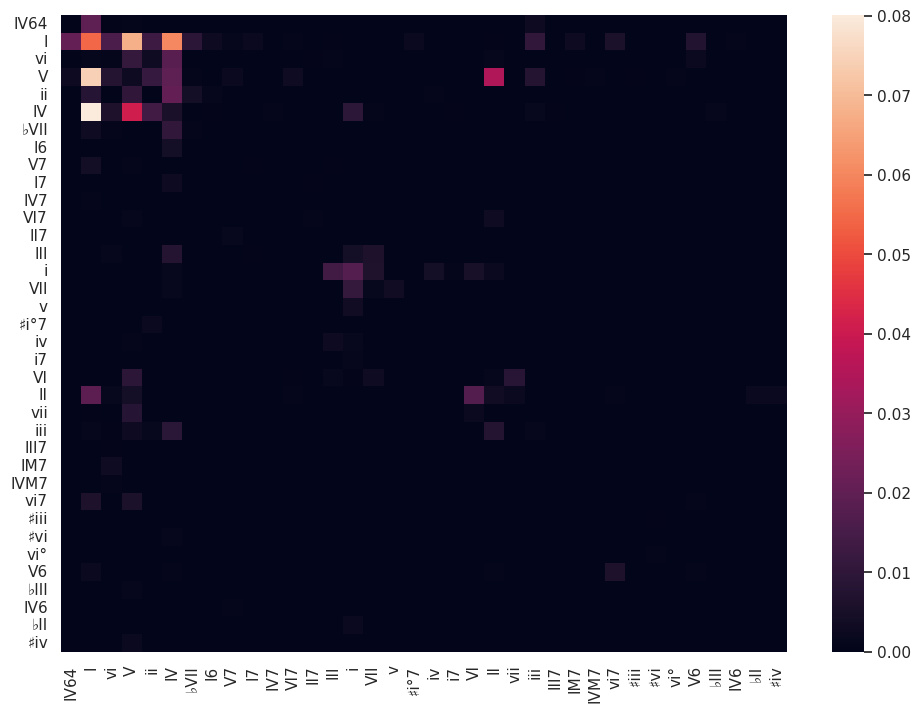

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
_ = sns.heatmap(coocc['Country'])

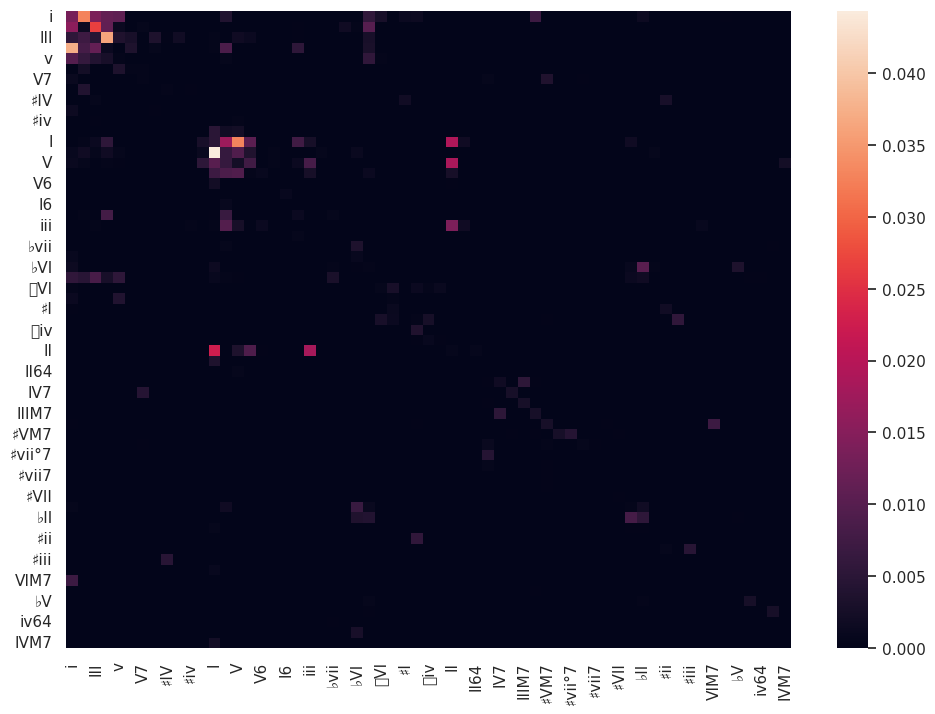

In [21]:
_ = sns.heatmap(coocc['Electronic'])

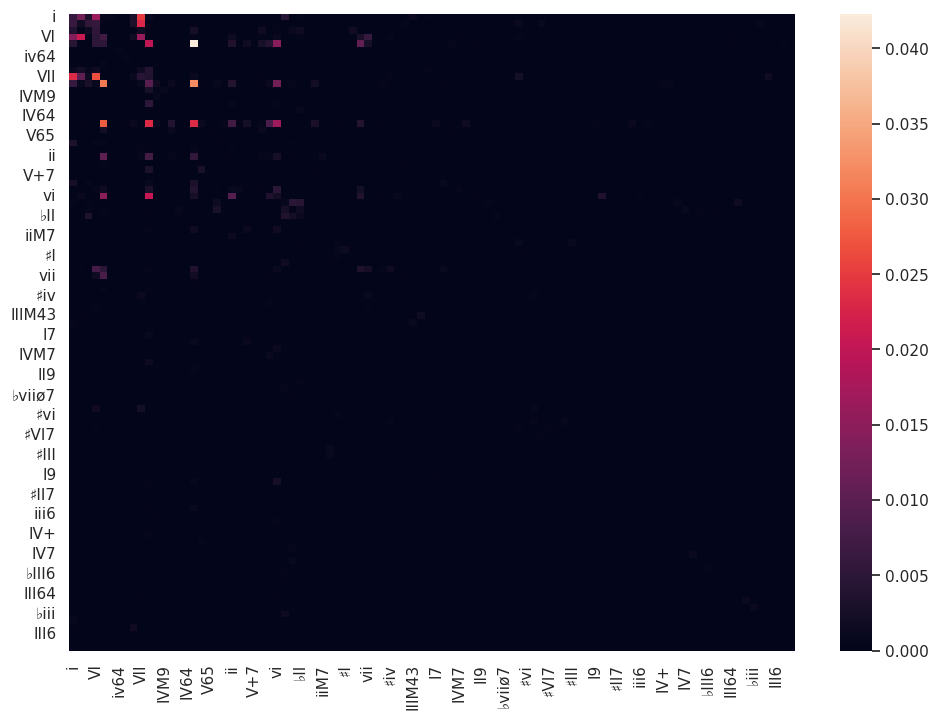

In [22]:
_ = sns.heatmap(coocc['Pop'])

Get only values that have at least one co-occurence of > 100

In [23]:
above_100_mask = (coocc['Rock'] > 0.01).any()
rock_100 = coocc['Rock'][above_100_mask][list(above_100_mask[above_100_mask == True].index)]

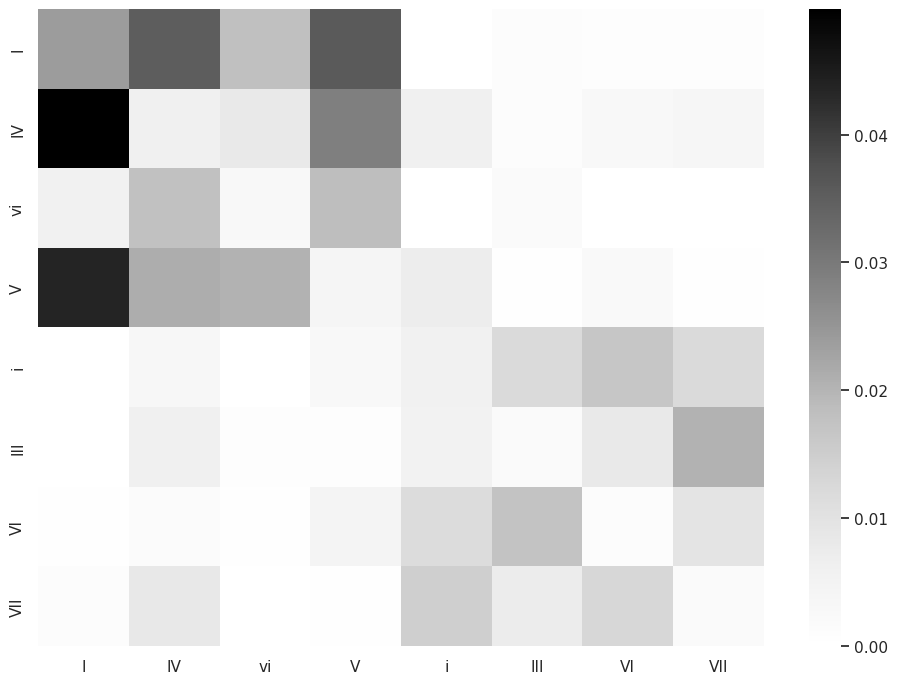

In [24]:
# sns.color_palette("deep")
_ = sns.heatmap(rock_100, cmap='Greys')

### Save nodelists and edgelists

In [25]:
for genre, df in dataframes.items():
    df.to_csv('edge_lists/edges_' + genre.lower() + '.csv', index=False)
    nodelists[genre].to_csv('node_lists/nodes_' + genre.lower() + '.csv', index=False)

In [26]:
dataframes['Rock']

,Source,Target,sum_appearance,percent,log_ratio,probability
0,I,I,514,0.024046,-0.139830,0.145857
1,I,I64,16,0.000749,1.021095,0.004540
2,I,I7,19,0.000889,0.378845,0.005392
3,I,I9,4,0.000187,1.803854,0.001135
4,I,II,75,0.003509,0.095476,0.021283
...,...,...,...,...,...,...
915,♯vi7,VII,1,0.000047,2.866089,1.000000
916,♯vi°,♯iii,1,0.000047,6.406243,1.000000
917,♯v°,I,1,0.000047,-0.393370,0.111111
918,♯v°,v7,1,0.000047,4.296030,0.111111


In [27]:
nodelists['Country']

,Id,sum_appearance,percent,average_appearance
0,IV64,62,0.023592,2.066667
1,I,736,0.280061,24.533333
2,vi,101,0.038432,3.366667
3,V,442,0.168189,14.733333
4,ii,116,0.044140,3.866667
5,IV,423,0.160959,14.100000
6,♭VII,39,0.014840,1.300000
7,I6,11,0.004186,0.366667
8,V7,15,0.005708,0.500000
9,I7,8,0.003044,0.266667


# Smol EDA

In [28]:
enmax_palette = ["#31394d", '#d9c4b1']
sns.set_palette(palette=enmax_palette)

In [29]:
eda_dict = {}
for genre in number_of_songs.keys():
    eda_dict[genre] = [modes[genre].count('major'), modes[genre].count('minor')]

In [30]:
df_eda = pd.DataFrame(eda_dict).transpose()
df_eda.columns = ['major', 'minor']
df_eda

,major,minor
Country,25,5
Electronic,21,22
Pop,70,27
Rock,144,68


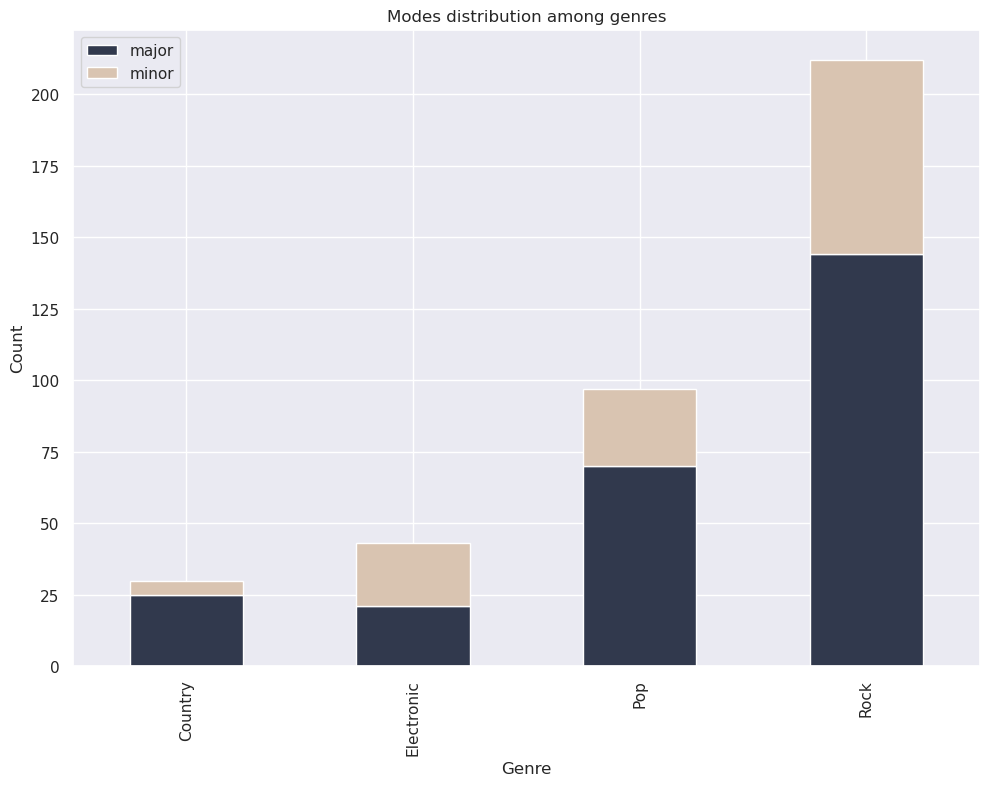

In [31]:
ax = df_eda.plot(kind='bar', stacked=True, color=['C0', 'C1'])
ax.set_xlabel('Genre')
ax.set_ylabel('Count')
_ = ax.set_title('Modes distribution among genres')

# Probability Transition - Rock

In [32]:
cols_rock_pop = list(set([*coocc['Pop'].columns, *coocc['Rock'].columns]))

In [33]:
prob_rock = coocc['Rock'].reindex(columns=cols_rock_pop, fill_value=0)
prob_rock = prob_rock.T
prob_rock = prob_rock.reindex(columns=cols_rock_pop, fill_value=0)
prob_rock = prob_rock.T

In [34]:
prob_pop = coocc['Pop'].reindex(columns=cols_rock_pop, fill_value=0)
prob_pop = prob_pop.T
prob_pop = prob_pop.reindex(columns=cols_rock_pop, fill_value=0)
prob_pop = prob_pop.T

In [35]:
diff_pop_rock = prob_rock - prob_pop

In [36]:
diff_pop_rock

,♯III,IV,V+7,iii,♯ii,♭VII64,i9,V,♯I7,IV6,...,viiø7,♭III,ii7,vii,V7,iv,VIIM9,VI7,♯VII+,♭II
♯III,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
IV,0.0,-0.003705,0.0,0.001176,0.0,-0.001281,-0.000634,-0.001586,0.0,0.001123,...,0.0,0.000781,0.001414,0.000047,0.000958,-0.000422,0.0,0.000094,0.0,0.000000
V+7,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
iii,0.0,0.001191,0.0,0.000047,0.0,0.000000,0.000000,-0.000628,0.0,0.000000,...,0.0,0.000000,0.001637,0.000000,-0.000177,0.000000,0.0,-0.000647,0.0,0.000000
♯ii,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iv,0.0,0.000094,0.0,0.000094,0.0,0.000000,0.000000,0.000362,0.0,0.000000,...,0.0,-0.001069,0.000000,0.000000,-0.001692,-0.001094,0.0,0.000140,0.0,-0.001305
VIIM9,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000702,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
VI7,0.0,0.000094,0.0,0.000000,0.0,0.000000,0.000000,-0.000529,0.0,0.000000,...,0.0,0.000000,-0.000317,0.000000,0.000047,0.000000,0.0,0.000000,0.0,0.000000
♯VII+,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [37]:
pop_rock_mask = ((diff_pop_rock > 0.005) | (diff_pop_rock < -0.005))
diff_pop_rock_filtered = diff_pop_rock[pop_rock_mask.any()].T[pop_rock_mask.any()].T

In [38]:
diff_pop_rock_filtered

,IV,iii,V,i,VI,vi,I,♭VII,VII,II,vii
IV,-0.003705,0.001176,-0.001586,0.000382,0.002195,-0.004324,0.017574,0.001634,0.002838,0.000362,0.000047
iii,0.001191,0.000047,-0.000628,0.000000,-0.000400,-0.002244,-0.002496,-0.000329,0.000187,-0.001565,0.000000
V,0.001455,-0.002568,-0.000818,0.002670,-0.002583,0.005958,0.001402,0.000749,0.000515,-0.006047,-0.001976
i,0.002018,-0.000211,0.002512,-0.000578,0.000313,0.000234,0.000000,0.000234,-0.012555,0.000000,-0.000211
VI,0.001485,0.000000,-0.002817,-0.002507,-0.003436,-0.000508,0.000092,-0.000059,-0.006457,-0.001966,-0.005138
vi,-0.002747,-0.000168,0.004028,-0.000211,0.000327,0.000892,0.003217,0.000936,0.000374,-0.002484,-0.000059
I,0.012071,-0.005019,0.007956,0.000281,0.000923,0.001246,0.000573,0.008175,0.000419,-0.000403,0.000187
♭VII,0.006737,0.000000,-0.000026,-0.002798,-0.000295,0.000631,0.006678,0.000572,0.000175,0.000047,0.000000
VII,0.004708,0.000000,0.000468,-0.008677,-0.013791,0.000000,0.000088,0.000281,-0.002535,0.000000,0.000000
II,0.000395,0.000561,-0.001894,0.000035,-0.004397,-0.000895,0.000441,0.000000,0.000000,-0.001758,-0.001730


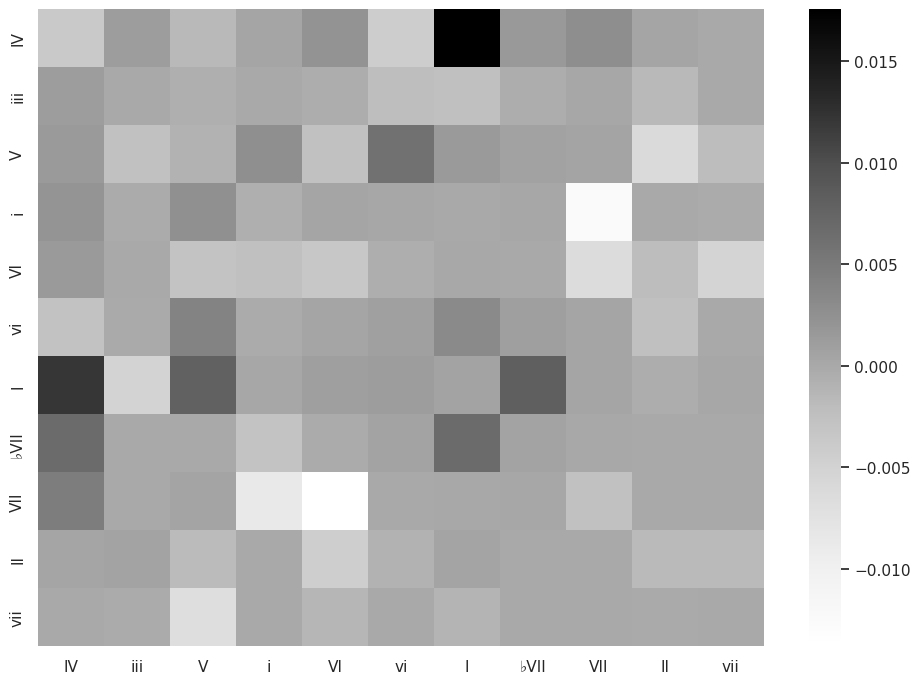

In [39]:
_ = sns.heatmap(diff_pop_rock_filtered, cmap='Greys')